In [1]:
!pip install pulp
!pip install rdkit-pypi

import itertools
import pulp
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.rdMolDescriptors import CalcExactMolWt
from IPython.display import display
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

  Using cached PuLP-2.9.0-py3-none-any.whl (17.7 MB)
  Using cached rdkit_pypi-2022.9.5-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (29.4 MB)


# Calculating edges and nodes using SMARTS 

In [2]:
# Step 1: Define initial data and molecule
cinnamic_acid_smiles = 'C1=CC=CC=C1/C=C/C(=O)O'
cinnamic_acid = Chem.MolFromSmiles(cinnamic_acid_smiles)

# Calculate initial molecule mass
initial_mass = CalcExactMolWt(cinnamic_acid)
print("Initial molecule (cinnamic acid) mass:", initial_mass)

# Define reaction for water loss
RXN = {
    'water': '[O;H2+:1][C:2]>>[C+:2].[O:1]',  # Water loss
}

# Convert SMARTS to reaction objects
reactions = {}
for name, smarts in neutral_losses.items():
    reactions[name] = AllChem.ReactionFromSmarts(smarts)

# Step 3: Apply ionisation and calculate ionised mass
ionisation_rxn = AllChem.ReactionFromSmarts('[O:1][C:2]>>[O+:1][C:2]')
product_sets = ionisation_rxn.RunReactants((cinnamic_acid,))
if product_sets:
    ionised_product = product_sets[0][0]
    Chem.SanitizeMol(ionised_product)
    ionised_mass = CalcExactMolWt(ionised_product)
    peaks_df = pd.DataFrame({'mz': [ionised_mass], 'intensity': [80.0]})

# Step 4: Apply each neutral loss reaction to the ionised product and calculate fragment masses
for loss_name, reaction in reactions.items():
    product_sets = reaction.RunReactants((ionised_product,))
    if product_sets:
        for product in product_sets:
            Chem.SanitizeMol(product[0])
            product_mass = CalcExactMolWt(product[0])
            peaks_df = pd.concat([peaks_df, pd.DataFrame({'mz': [product_mass], 'intensity': [50.0]})], ignore_index=True)

# Display updated peaks_df
print("\nUpdated peaks_df:\n", peaks_df)

# Step 6: Generate potential edges based on observed fragment losses in peaks_df
edges = []
tolerance = 0.5  # Tolerance for matching mass differences

for i, j in itertools.combinations(peaks_df.index, 2):
    mz_diff = abs(peaks_df.loc[i, 'mz'] - peaks_df.loc[j, 'mz'])
    if abs(mz_diff - 18.0) <= tolerance:  # Only water loss
        edges.append((i, j))

# Step 7: Calculate transition probabilities for each edge based on the preceding node
transition_probabilities = {}
for (i, j) in edges:
    precursor_intensity = peaks_df.loc[i, 'intensity']
    fragment_intensity = peaks_df.loc[j, 'intensity']
    transition_prob = precursor_intensity / fragment_intensity if fragment_intensity != 0 else 0
    transition_probabilities[(i, j)] = transition_prob

# Step 8: Set up ILP problem for subtree optimization
node_vars = pulp.LpVariable.dicts("node", peaks_df.index, 0, 1, pulp.LpBinary)
edge_vars = pulp.LpVariable.dicts("edge", edges, 0, 1, pulp.LpBinary)

# Initialize the ILP problem
prob = pulp.LpProblem("MaximizeNodesWithTransitionProbabilities", pulp.LpMaximize)

# Objective: Maximize the number of nodes in the subtree
prob += pulp.lpSum([node_vars[n] for n in peaks_df.index]), "Maximize number of nodes"

# Constraints: If an edge is selected, both nodes must be selected
for u, v in edges:
    prob += edge_vars[(u, v)] <= node_vars[u], f"Edge_{u}_{v}_u"
    prob += edge_vars[(u, v)] <= node_vars[v], f"Edge_{u}_{v}_v"
    prob += edge_vars[(u, v)] >= node_vars[u] + node_vars[v] - 1, f"Edge_{u}_{v}_connection"

# Optional: Add transition probability constraints
min_transition_prob = 0.2
for (u, v) in edges:
    prob += edge_vars[(u, v)] * transition_probabilities[(u, v)] >= min_transition_prob * edge_vars[(u, v)], f"MinProb_{u}_{v}"

# Solve the ILP problem
prob.solve()

# Display results
print("\nStatus:", pulp.LpStatus[prob.status])
print("Selected nodes in the subtree:")
for n in peaks_df.index:
    if node_vars[n].varValue == 1:
        print(f"Node {n} with m/z {peaks_df.loc[n, 'mz']}, intensity {peaks_df.loc[n, 'intensity']} is in the subtree.")

print("Selected edges in the subtree with transition probabilities:")
for e in edges:
    if edge_vars[e].varValue == 1:
        print(f"Edge {e} with transition probability {transition_probabilities[e]:.2f} is in the subtree.")


Initial molecule (cinnamic acid) mass: 148.052429496

Updated peaks_df:
            mz  intensity
0  149.059706       80.0
1  131.049141       50.0
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/1f77e1d3dd55406bac206c6c8b3fe4b6-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/1f77e1d3dd55406bac206c6c8b3fe4b6-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 9 COLUMNS
At line 26 RHS
At line 31 BOUNDS
At line 35 ENDATA
Problem MODEL has 4 rows, 3 columns and 8 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 2 - 0.00 seconds
Cgl0004I processed model has 3 rows, 3 columns (3 integer (3 of which binary)) and 7 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution fou

# Plotting the computed fragmentation tree

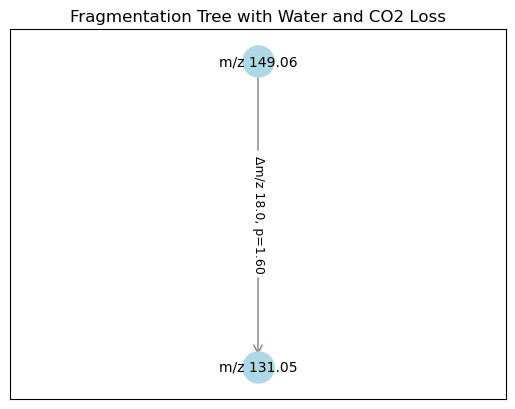

In [3]:
# Visualization code as provided before to plot nodes and edges with transition probabilities

# Create a directed graph
G = nx.DiGraph()

# Add nodes (peaks) to the graph
for idx, row in peaks_df.iterrows():
    G.add_node(idx, label=f"m/z {row['mz']:.2f}")

# Add edges with m/z differences and transition probabilities as labels
mz_differences = {}
for (u, v) in transition_probabilities.keys():
    if edge_vars[(u, v)].varValue == 1:  # Only add edges selected in the subtree
        mz_diff = abs(peaks_df.loc[u, 'mz'] - peaks_df.loc[v, 'mz'])
        G.add_edge(u, v, label=f"Δm/z {mz_diff:.1f}, p={transition_probabilities[(u, v)]:.2f}")
        mz_differences[(u, v)] = mz_diff

# Calculate node levels (distance from the precursor node)
# Assuming the precursor is the node with the largest m/z (i.e., the root)
precursor_node = peaks_df['mz'].idxmax()  # Node with the largest m/z

# Get the shortest path length from the precursor to each node (i.e., tree depth)
node_depths = nx.single_source_shortest_path_length(G, precursor_node)

# Group nodes by their depth (level in the tree)
levels = {}
for node, depth in node_depths.items():
    if depth not in levels:
        levels[depth] = []
    levels[depth].append(node)

# Custom layout based on depth (levels) and horizontal spread
pos = {}
horizontal_spacing = 2.0  # Spacing between nodes at the same level
vertical_spacing = 1.5    # Spacing between levels

for depth, nodes in levels.items():
    # Spread nodes horizontally at each level
    num_nodes = len(nodes)
    for i, node in enumerate(nodes):
        pos[node] = (i * horizontal_spacing - num_nodes * horizontal_spacing / 2, -depth * vertical_spacing)

# Draw the nodes
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue')

# Draw the edges
nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=15, edge_color='gray')

# Draw the node labels (m/z values)
node_labels = nx.get_node_attributes(G, 'label')
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10, font_color='black')

# Draw the edge labels (m/z differences and transition probabilities)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)

# Set plot title
plt.title("Fragmentation Tree with Water and CO2 Loss")

# Show the plot
plt.show()


# Cosine Similarity

In [4]:


# Function to normalize spectrum to max intensity of 1
def normalize_spectrum(spectrum):
    max_intensity = spectrum['intensity'].max()
    spectrum['intensity'] = spectrum['intensity'] / max_intensity
    return spectrum

# Function to calculate intensities for each fragment node based on the tree and transition probabilities
def calculate_intensities_from_tree(tree_edges, precursor_intensity, transition_probs):
    intensities = {tree_edges[0][0]: precursor_intensity}  # Initialize with precursor node intensity

    for (u, v) in tree_edges:
        if u in intensities:  # If precursor intensity is known
            intensities[v] = intensities[u] * transition_probs[(u, v)]
    return intensities

# Function to back-calculate the spectrum from the tree and transition probabilities
def back_calculate_spectrum_from_tree(tree_nodes, tree_edges, peaks_df, transition_probs):
    precursor_intensity = peaks_df.loc[tree_nodes[0], 'intensity']  # Precursor's intensity
    calculated_intensities = calculate_intensities_from_tree(tree_edges, precursor_intensity, transition_probs)
    
    back_calculated_spectrum = peaks_df.loc[tree_nodes][['mz']].copy()
    back_calculated_spectrum['intensity'] = back_calculated_spectrum.index.map(calculated_intensities)
    
    # Normalize the back-calculated spectrum
    back_calculated_spectrum = normalize_spectrum(back_calculated_spectrum)
    
    return back_calculated_spectrum

# Align the m/z values of the original and back-calculated spectra
def align_spectra(original_spectrum, calculated_spectrum):
    merged_spectrum = pd.merge(original_spectrum, calculated_spectrum, on='mz', how='outer', suffixes=('_orig', '_calc')).fillna(0)
    return merged_spectrum

# Calculate cosine similarity between original and back-calculated spectra
def calculate_cosine_similarity(merged_spectrum):
    original_intensities = merged_spectrum['intensity_orig'].values.reshape(1, -1)
    calculated_intensities = merged_spectrum['intensity_calc'].values.reshape(1, -1)
    similarity = cosine_similarity(original_intensities, calculated_intensities)[0, 0]
    return similarity

# Extract unique nodes from edges
def calculate_nodes_from_edges(edges):
    nodes = set()
    for u, v in edges:
        nodes.add(u)
        nodes.add(v)
    return list(nodes)

# Example usage to calculate cosine similarity
selected_nodes = calculate_nodes_from_edges(edges)  # Nodes selected by ILP in the fragmentation tree
original_spectrum = peaks_df[['mz', 'intensity']].copy()
original_spectrum = normalize_spectrum(original_spectrum)
print("\nOriginal spectrum (normalized):\n", original_spectrum)

back_calculated_spectrum = back_calculate_spectrum_from_tree(selected_nodes, edges, peaks_df, transition_probabilities)
print("\nBack-calculated spectrum (normalized):\n", back_calculated_spectrum)

merged_spectrum = align_spectra(original_spectrum, back_calculated_spectrum)
cosine_sim = calculate_cosine_similarity(merged_spectrum)

print(f"Cosine Similarity between original and back-calculated spectra (normalized): {cosine_sim:.4f}")



Original spectrum (normalized):
            mz  intensity
0  149.059706      1.000
1  131.049141      0.625

Back-calculated spectrum (normalized):
            mz  intensity
0  149.059706      0.625
1  131.049141      1.000
Cosine Similarity between original and back-calculated spectra (normalized): 0.8989


In [5]:
edges

[(0, 1)]

In [6]:
nodes

[1]